In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

from tabulate import tabulate
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import random as py_random
import scipy.stats as stats

sns.set(style="whitegrid")

# Extract, Transform, Load (ETL)

At this point, we should have:

1. `meetup.sql` will create the data schema.
2. `meetup.py` will fill the database tables with the correct data from the meetup JSON.
3. `meetup.db` will have the data in it.

In [3]:
conn = sqlite3.connect('../2 - get/meetup.db')
cursor = conn.cursor()

Before we start with the exploratory data analysis, let us examine the dataset to get a feeling of the sort of data we are handling.

As a summary from the "Ask" part of the assignment, here are some questions to bear in mind while doing the analysis.
1. What kind of events draw the most reservation? Board games? Karaoke? Hiking?
1. What day of the week is the most popular?
1. What time of the day do most members RSVP?
1. How many events have we had in total in the past years? Are we collectively becoming more popular as a group?
1. Are members more inclined to join events that are relatively more popular? What are some of the most popular events and what do they have in common?
1. When members RSVP for an event, the data should provide information about this time. Is there a time that is more favorable to announce an event?

We can start by peeking at the schema. Limit to just first 30 rows.

Event can be viewed with URL https://www.meetup.com/{group_name}/events/{event_id}/

For example, if the event ID is 281289732 for 1-5GenAsians group, https://www.meetup.com/1-5GenAsians/events/281289732/

In [4]:
data = cursor.execute("select event_id,event_date, rsvp_count, venue_lat, venue_lon, venue_city from event limit 30;")
print(tabulate(data.fetchall(), headers=["Event ID", "Event Date", 'RSVP Count', "Lat", "Lon", "City"], tablefmt='psql'))

+------------+--------------+--------------+---------+----------+---------------+
|   Event ID | Event Date   |   RSVP Count |     Lat |      Lon | City          |
|------------+--------------+--------------+---------+----------+---------------|
|  109370632 | 2013-03-22   |            5 | 47.6816 | -122.126 | Redmond       |
|  109868492 | 2013-03-23   |            6 | 47.5287 | -121.825 | Snoqualmie    |
|  111080172 | 2013-03-30   |           11 | 47.612  | -122.199 | Bellevue      |
|  111088522 | 2013-03-30   |            3 | 48.0043 | -122.214 | Everett 98201 |
|  110749042 | 2013-03-31   |            8 | 47.6034 | -122.201 | Bellevue      |
|  111871212 | 2013-04-05   |           10 | 47.6098 | -122.204 | Bellevue      |
|  112504332 | 2013-04-06   |            8 | 47.667  | -122.1   | Redmond       |
|  113192492 | 2013-04-12   |           10 | 47.62   | -122.202 | Bellevue      |
|  113176612 | 2013-04-13   |            4 | 47.6573 | -122.318 | Seattle       |
|  114838502 | 2

Let's see some of the most popular events. I define this to be events with the most RSVP.

In [5]:
data = cursor.execute("select event_date, rsvp_count, event_id from event order by rsvp_count desc limit 15;")
print(tabulate(data.fetchall(), headers=['Event Date', 'RSVP Count', 'Event ID'], tablefmt='psql'))

+--------------+--------------+------------+
| Event Date   |   RSVP Count |   Event ID |
|--------------+--------------+------------|
| 2015-03-01   |          109 |  219920453 |
| 2014-11-02   |          105 |  212049012 |
| 2016-10-09   |          102 |  233570064 |
| 2016-04-30   |           85 |  230305968 |
| 2019-12-21   |           83 |  266398172 |
| 2018-03-24   |           82 |  248285057 |
| 2018-06-10   |           80 |  250424473 |
| 2021-08-29   |           69 |  279628714 |
| 2014-08-17   |           57 |  194901992 |
| 2019-01-26   |           54 |  257948178 |
| 2015-03-14   |           47 |  220103990 |
| 2021-10-17   |           46 |  281053389 |
| 2014-06-21   |           44 |  182543572 |
| 2017-10-14   |           43 |  243442670 |
| 2014-03-29   |           40 |  164683122 |
+--------------+--------------+------------+


In [6]:
data = cursor.execute("select count(*) from event;")
print(f"Total number of events is {data.fetchone()[0]}")

Total number of events is 814


Let's see the number of events we have for each month since this group was founded in 2013.

In [7]:
num_event_per_month = list(cursor.execute("""select strftime('%Y-%m', event_date), count(*) from event 
    group by strftime('%Y-%m', event_date);"""))
print(tabulate(num_event_per_month, headers=['Month', 'Number of Events'], tablefmt='psql'))

+---------+--------------------+
| Month   |   Number of Events |
|---------+--------------------|
| 2013-03 |                  5 |
| 2013-04 |                  5 |
| 2013-05 |                  5 |
| 2013-06 |                  5 |
| 2013-07 |                  5 |
| 2013-08 |                  4 |
| 2013-09 |                  4 |
| 2013-10 |                  7 |
| 2013-11 |                  9 |
| 2013-12 |                  6 |
| 2014-01 |                  7 |
| 2014-02 |                  3 |
| 2014-03 |                  3 |
| 2014-04 |                  7 |
| 2014-05 |                 11 |
| 2014-06 |                  4 |
| 2014-07 |                  3 |
| 2014-08 |                  4 |
| 2014-09 |                  4 |
| 2014-10 |                  8 |
| 2014-11 |                  4 |
| 2014-12 |                  2 |
| 2015-01 |                  6 |
| 2015-02 |                  6 |
| 2015-03 |                  6 |
| 2015-04 |                  4 |
| 2015-05 |                  3 |
| 2015-06 

Looks like there was a big spike after July 2022. This was when Coronavirus quarantine and regulations were more relaxed in Seattle and people were able to enjoy more festive events and activities. My guess is that people were tired of being cooped up at home for over a year and a half so now they are eager to go out and socialize.

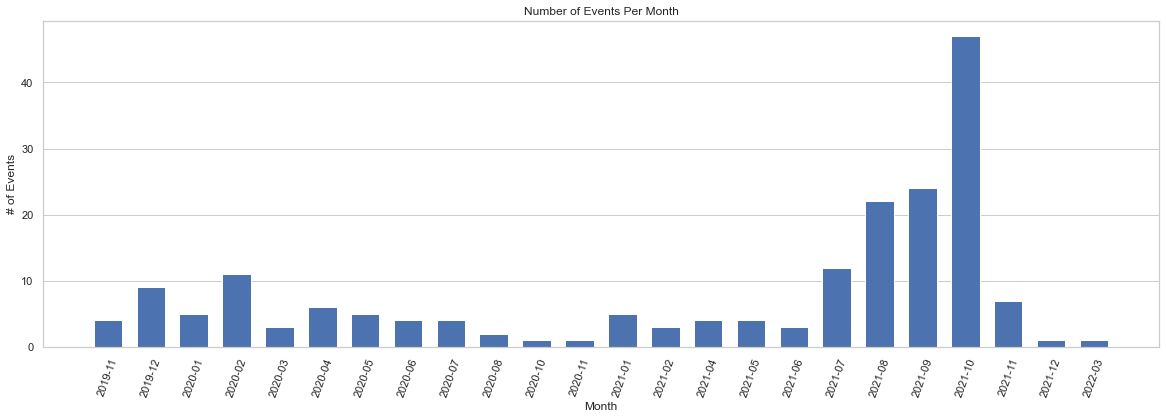

In [8]:
num_event_per_month = list(num_event_per_month)[-24:]
x = range(len(num_event_per_month))
width = 1/1.5

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, [r[1] for r in num_event_per_month], width, align="center")
axes.set_xticks(x)
axes.set_xticklabels([r[0] for r in num_event_per_month])
axes.set_title("Number of Events Per Month")
axes.set_xlabel("Month")
axes.set_ylabel("# of Events")
axes.xaxis.grid(False)

plt.setp(axes.xaxis.get_majorticklabels(), rotation=70)
plt.show()
plt.close();

Next, I'm interested to see how many events we have per year and the number of events we hold per weekday

+--------+--------------------+
|   Year |   Number of Events |
|--------+--------------------|
|   2013 |                 55 |
|   2014 |                 60 |
|   2015 |                 83 |
|   2016 |                 98 |
|   2017 |                 39 |
|   2018 |                165 |
|   2019 |                139 |
|   2020 |                 42 |
|   2021 |                132 |
|   2022 |                  1 |
+--------+--------------------+


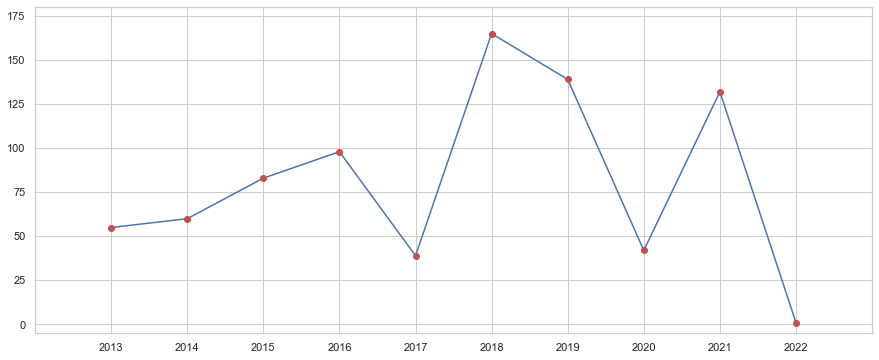

In [9]:
num_event_per_year = list(cursor.execute("""select strftime('%Y', event_date), count(*) from event 
    group by strftime('%Y', event_date);"""))
print(tabulate(num_event_per_year, headers=['Year', 'Number of Events'], tablefmt='psql'))

figure = plt.figure(figsize=(15, 6))

axes = figure.add_subplot(1, 1, 1)
axes.plot([r[0] for r in num_event_per_year], [r[1] for r in num_event_per_year])
axes.plot([r[0] for r in num_event_per_year], [r[1] for r in num_event_per_year], 'ro')
plt.axis([-1, 10, -5, 180])
plt.show()

2020 experienced a low dip most definitely due to the pandemic. The data (through inspection) preliminarily suggests that most events were online but rose to face to face interaction starting back in 2021.

In [10]:
num_event_per_weekday = list(cursor.execute("""select strftime('%w', event_date), count(*) from event 
    group by strftime('%w', event_date);"""))
print(tabulate(num_event_per_weekday, headers=['Day of the Week', 'Number of Events'], tablefmt='psql'))

+-------------------+--------------------+
|   Day of the Week |   Number of Events |
|-------------------+--------------------|
|                 0 |                278 |
|                 1 |                 19 |
|                 2 |                 23 |
|                 3 |                 43 |
|                 4 |                 37 |
|                 5 |                102 |
|                 6 |                312 |
+-------------------+--------------------+


No surprise there. Weekends are the most popular days to host events

In [11]:
events = pd.read_sql('SELECT * FROM event', conn)
events.head()

,event_id,status,event_date,event_time,rsvp_count,waitlist_count,duration,venue_lat,venue_lon,venue_city,link
0,109370632,past,2013-03-22,19:00,5,0,0.0,47.681561,-122.125504,Redmond,https://www.meetup.com/1-5GenAsians/events/109...
1,109868492,past,2013-03-23,12:30,6,0,0.0,47.528713,-121.825394,Snoqualmie,https://www.meetup.com/1-5GenAsians/events/109...
2,111080172,past,2013-03-30,10:00,11,0,0.0,47.612015,-122.198830,Bellevue,https://www.meetup.com/1-5GenAsians/events/111...
3,111088522,past,2013-03-30,12:00,3,0,0.0,48.004272,-122.214149,Everett 98201,https://www.meetup.com/1-5GenAsians/events/111...
4,110749042,past,2013-03-31,17:00,8,0,0.0,47.603401,-122.201317,Bellevue,https://www.meetup.com/1-5GenAsians/events/110...


In [12]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_id        814 non-null    object 
 1   status          814 non-null    object 
 2   event_date      814 non-null    object 
 3   event_time      814 non-null    object 
 4   rsvp_count      814 non-null    int64  
 5   waitlist_count  814 non-null    int64  
 6   duration        814 non-null    float64
 7   venue_lat       762 non-null    float64
 8   venue_lon       762 non-null    float64
 9   venue_city      762 non-null    object 
 10  link            814 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 70.1+ KB


We need to make a few modifications. Event ID should really be an int64 but string is fine too, there won't be much to analyze on this property so we can just leave it alone. Status tells us whether the event was in the past or upcoming, we don't need this information. The venue city and event time should be categorial. Duration is expressed in terms of milliseconds. We will want to convert this to hours. Finally, the links can be useful to redirect to the Meetup page but not so much for analysis so let's remove that as well.

In [13]:
events['event_id'] = events['event_id'].astype('str')
events['venue_city'] = events['venue_city'].astype('category')
events['event_time'] = events['event_time'].astype('category')
events = events.drop('status', 1)
events = events.drop('link', 1)
events['duration'] = events['duration'] / 3600000
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   event_id        814 non-null    object  
 1   event_date      814 non-null    object  
 2   event_time      814 non-null    category
 3   rsvp_count      814 non-null    int64   
 4   waitlist_count  814 non-null    int64   
 5   duration        814 non-null    float64 
 6   venue_lat       762 non-null    float64 
 7   venue_lon       762 non-null    float64 
 8   venue_city      762 non-null    category
dtypes: category(2), float64(3), int64(2), object(2)
memory usage: 50.3+ KB


# Exploratory Data Analysis (EDA)

## Single Variable Exploration

Let's begin our single variable exploration first and then analyze the pairwise relationships!

#### Event Time

       event_time
00:00           3
03:00           1
05:00           1
06:30           3
07:00           4
...           ...
20:45           1
21:00           5
21:15           1
22:00           1
23:59           1

[74 rows x 1 columns]


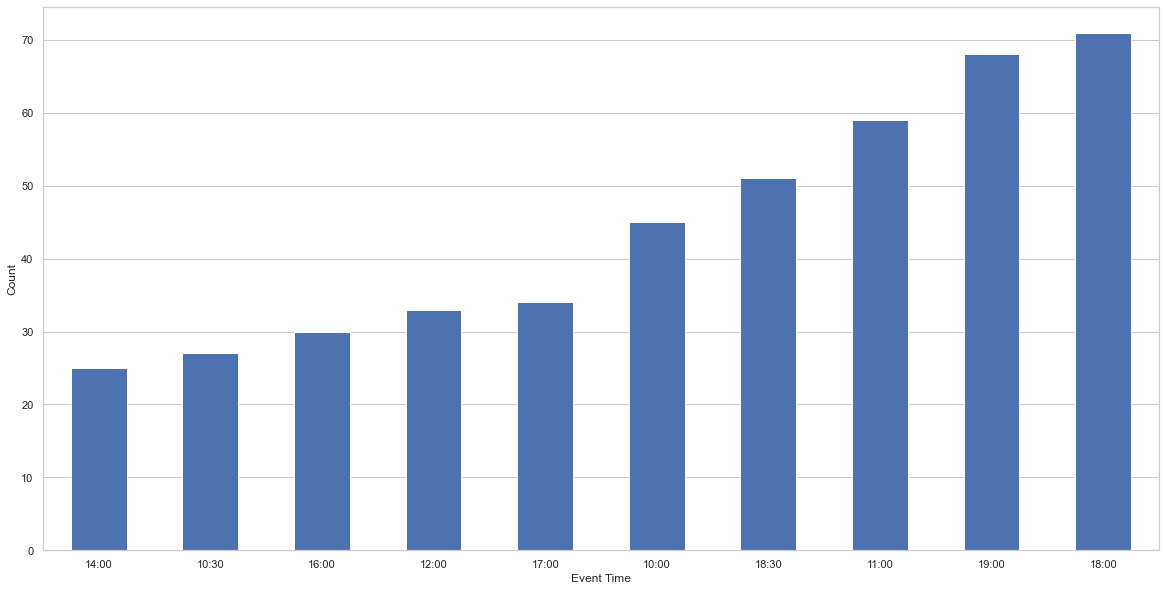

In [14]:
print(pd.DataFrame(events.event_time.value_counts().sort_index()))
ax = events.event_time.value_counts().sort_values().tail(10).plot.bar(figsize=(20,10),rot = 0)
ax.set_ylabel("Count")
ax.set_xlabel("Event Time")
ax.grid(axis='x')

In [15]:
events.event_time.describe()

count       814
unique       74
top       18:00
freq         71
Name: event_time, dtype: object

6 PM seems to be the most common time to host events. Event time may be a good indicator of a variable for linear regression in the later part.

#### RSVP

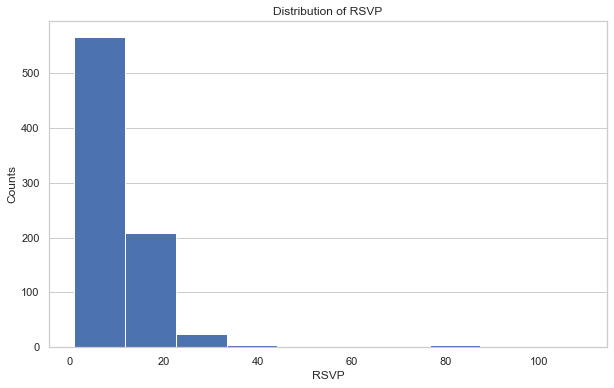

In [16]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(events.rsvp_count)
axes.set_title("Distribution of RSVP")
axes.set_xlabel("RSVP")
axes.set_ylabel("Counts")
axes.grid(axis='x')
plt.show()
plt.close()

In [17]:
events.rsvp_count.describe()

count    814.000000
mean      10.968059
std       10.296775
min        1.000000
25%        6.000000
50%        9.000000
75%       12.000000
max      109.000000
Name: rsvp_count, dtype: float64

Looks like most reservations are between 1 to 30. There appears to be some big events that host up to 90 members.

#### Waitlist Count

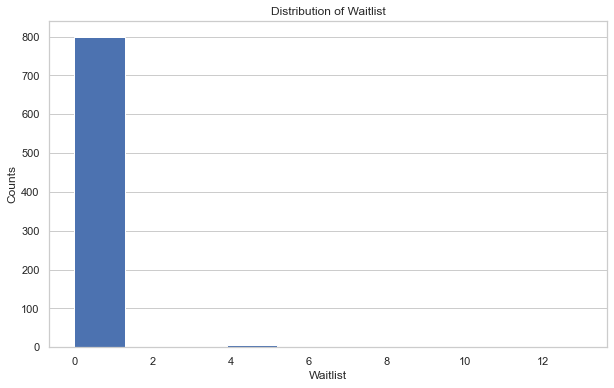

In [18]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(events.waitlist_count)
axes.set_title("Distribution of Waitlist")
axes.set_xlabel("Waitlist")
axes.set_ylabel("Counts")
axes.grid(axis='x')
plt.show()
plt.close()

In [19]:
events.waitlist_count.describe()

count    814.000000
mean       0.108108
std        0.853678
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       13.000000
Name: waitlist_count, dtype: float64

Almost every event is accounted as there doesn't seem to be much of any waitlist. This is not a good variable for analysis for our linear model later.

#### Venue City

                             venue_city
Auburn                                1
Beijing                               1
Bellevue                            228
Bellevue                              6
Berlin                                1
Bothell                               3
Burien                                1
Edmonds                               5
Everett                               3
Everett 98201                         1
Federal Way                           6
Gold Bar                              3
Index                                 1
Issaquah                             28
Kenmore                               1
Kent                                  1
Kirkland                             47
Kirkland                              1
Lake Forest Park                      1
Lynnwood                              6
Marysville                            1
Mercer Island                         4
Monroe                                2
Mount Vernon                          1


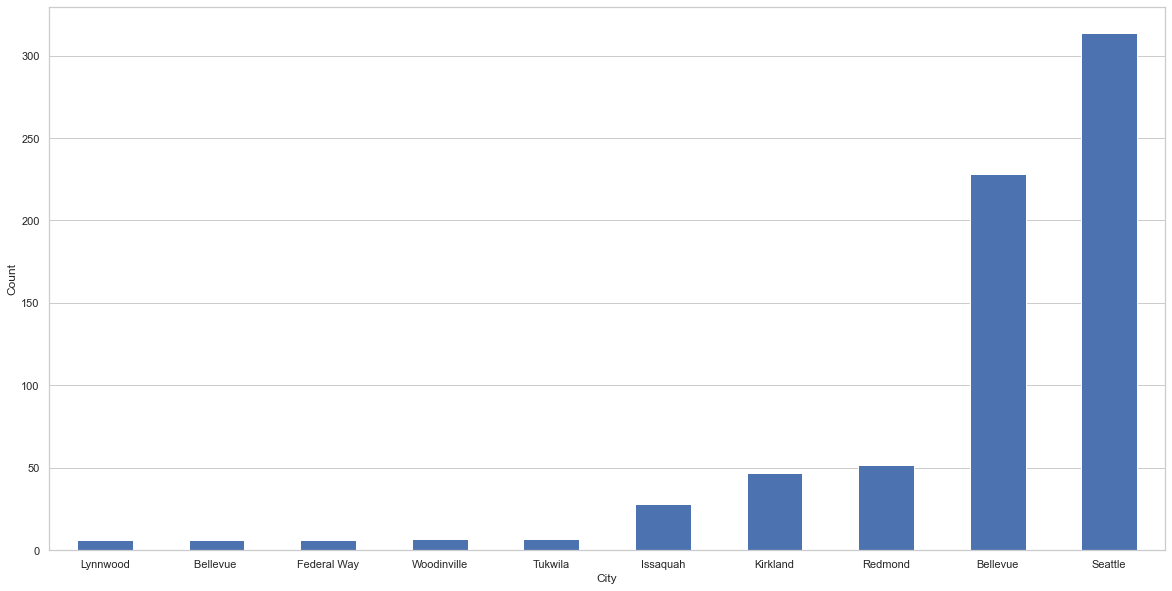

In [20]:
print(pd.DataFrame(events.venue_city.value_counts().sort_index()))

# Sort venue cities by the count and then sort before plotting top 10 most frequented cities
ax = events.venue_city.value_counts().sort_values().tail(10).plot.bar(figsize=(20,10),rot = 0)
ax.set_ylabel("Count")
ax.set_xlabel("City")
ax.grid(axis='x')

Bellueve and Seattle are the happening cities to host events! It'll be interesting to apply Random Forest technique on this variable.

#### Duration

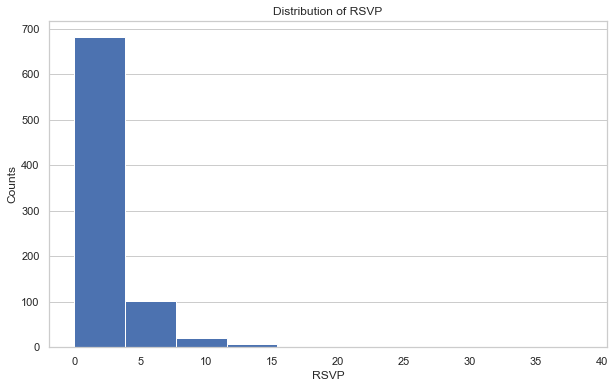

In [21]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.hist(events.duration)
axes.set_title("Distribution of RSVP")
axes.set_xlabel("RSVP")
axes.set_ylabel("Counts")
axes.grid(axis='x')
plt.show()
plt.close()

In [22]:
events.duration.describe()

count    814.000000
mean       2.474918
std        2.740083
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       38.500000
Name: duration, dtype: float64

## Pairwise Relationships

Because my questions revolve around the popularity of the events, the variable of interest to compare with is going to be the count of the reservations.

#### RSVP versus Cities

Let's revisit some of the most common venues of the events.

In [23]:
print(pd.DataFrame(events.venue_city.value_counts().sort_values().tail(10)))

             venue_city
Lynnwood              6
Bellevue              6
Federal Way           6
Woodinville           7
Tukwila               7
Issaquah             28
Kirkland             47
Redmond              52
Bellevue            228
Seattle             314


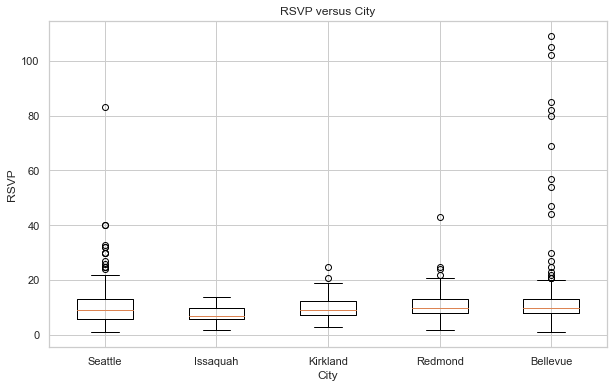

In [24]:
grouped_by_sex = events.groupby("venue_city")

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
labels = ["Seattle","Issaquah","Kirkland","Redmond","Bellevue"]
grouped_data = [grouped_by_sex["rsvp_count"].get_group(k) for k in labels]
patch = axes.boxplot(grouped_data, labels=labels)
axes.set_xlabel("City")
axes.set_ylabel("RSVP")
axes.set_title("RSVP versus City")

plt.show()
plt.close()

Wow, Bellevue has higher ranges than the other top 4 cities.

#### RSVP versus Event Duration

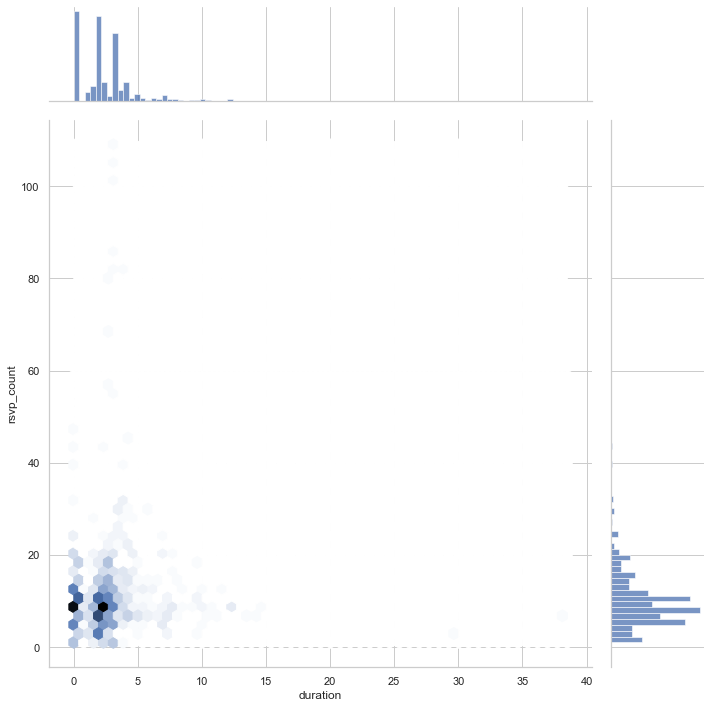

In [25]:
sns.jointplot(data=events, x = "duration", y = "rsvp_count", kind="hex", height=10)

There is no correlation between the duration of the event and the number of reservations. This suggests that members don't necessarily click on the Attend button based on how long the events are!

#### RSVP versus Event Time

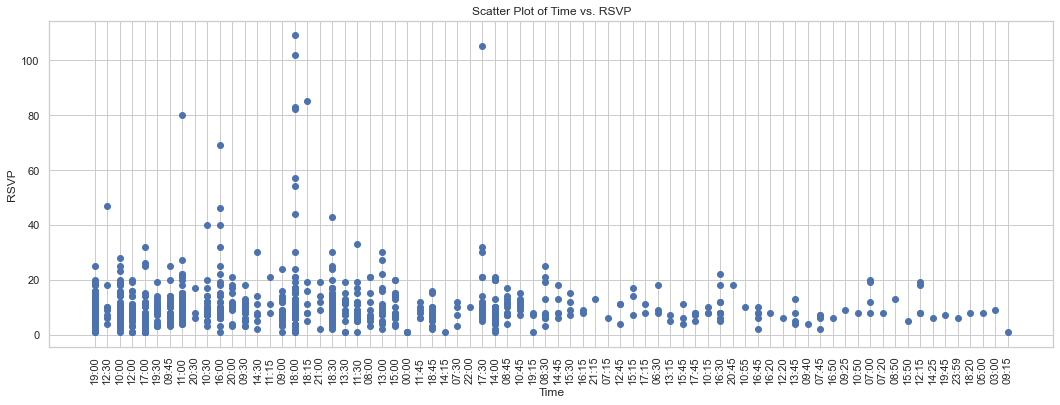

In [26]:
figure = plt.figure(figsize=(18, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(events.event_time, events.rsvp_count, marker="o")

axes.set_ylabel("RSVP")
axes.set_xlabel("Time")
axes.set_title("Scatter Plot of Time vs. RSVP")
plt.xticks(rotation = 90) 
plt.show()
plt.close()

We might need to use more sophisticated modeling techniques.